In [1]:
%load_ext autoreload
%autoreload 2

import warnings

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import polars as pl
import seaborn.objects as so

import tenforty

%matplotlib inline

In [ ]:
def make_currency_formatter(precision=0):
    """Create a currency tick formatter with configurable precision."""

    def formatter(x, pos):
        if x >= 1000:
            return f"${x / 1000:.{precision}f}K"
        return f"${x:.0f}"

    return formatter


def plain_currency_formatter(x, pos):
    """Format currency without K suffix, e.g. $13,500."""
    return f"${x:,.0f}"


def save_seaborn_objects_plot(plot, filename):
    """Apply common theme and work around seaborn legend clipping.

    https://github.com/mwaskom/seaborn/issues/3057
    """
    (
        plot.theme(
            {
                "font.sans-serif": "Roboto",
                "figure.facecolor": "white",
            }
        )
        .layout(engine="tight")
        .save(filename, bbox_inches="tight")
    )

In [4]:
tenforty.evaluate_return(
    w2_income=100_000, state="CA", filing_status="Married/Joint", num_dependents=2
).model_dump()

{'total_tax': 8876.0,
 'federal_adjusted_gross_income': 100000.0,
 'federal_effective_tax_rate': 11.3,
 'federal_tax_bracket': 12.0,
 'federal_taxable_income': 68500.0,
 'federal_amt': 0.0,
 'federal_total_tax': 7746.0,
 'state_adjusted_gross_income': 100000.0,
 'state_taxable_income': 88588.0,
 'state_total_tax': 1130.0,
 'state_tax_bracket': 6.0,
 'state_effective_tax_rate': 2.7}

In [5]:
print(
    tenforty.evaluate_returns(
        w2_income=list(range(50_000, 250_001, 50_000)),
        state="CA",
        filing_status="Married/Joint",
        num_dependents=2,
    )[
        [
            "w2_income",
            "federal_effective_tax_rate",
            "federal_tax_bracket",
            "state_effective_tax_rate",
            "state_tax_bracket",
        ]
    ]
)

shape: (5, 5)
┌───────────┬──────────────────────┬─────────────────────┬─────────────────────┬───────────────────┐
│ w2_income ┆ federal_effective_ta ┆ federal_tax_bracket ┆ state_effective_tax ┆ state_tax_bracket │
│ ---       ┆ x_rate               ┆ ---                 ┆ _rate               ┆ ---               │
│ i64       ┆ ---                  ┆ f64                 ┆ ---                 ┆ f64               │
│           ┆ f64                  ┆                     ┆ f64                 ┆                   │
╞═══════════╪══════════════════════╪═════════════════════╪═════════════════════╪═══════════════════╡
│ 50000     ┆ 10.0                 ┆ 10.0                ┆ 1.4                 ┆ 2.0               │
│ 100000    ┆ 11.3                 ┆ 12.0                ┆ 2.7                 ┆ 6.0               │
│ 150000    ┆ 13.4                 ┆ 22.0                ┆ 4.2                 ┆ 8.0               │
│ 200000    ┆ 16.0                 ┆ 22.0                ┆ 5.5               

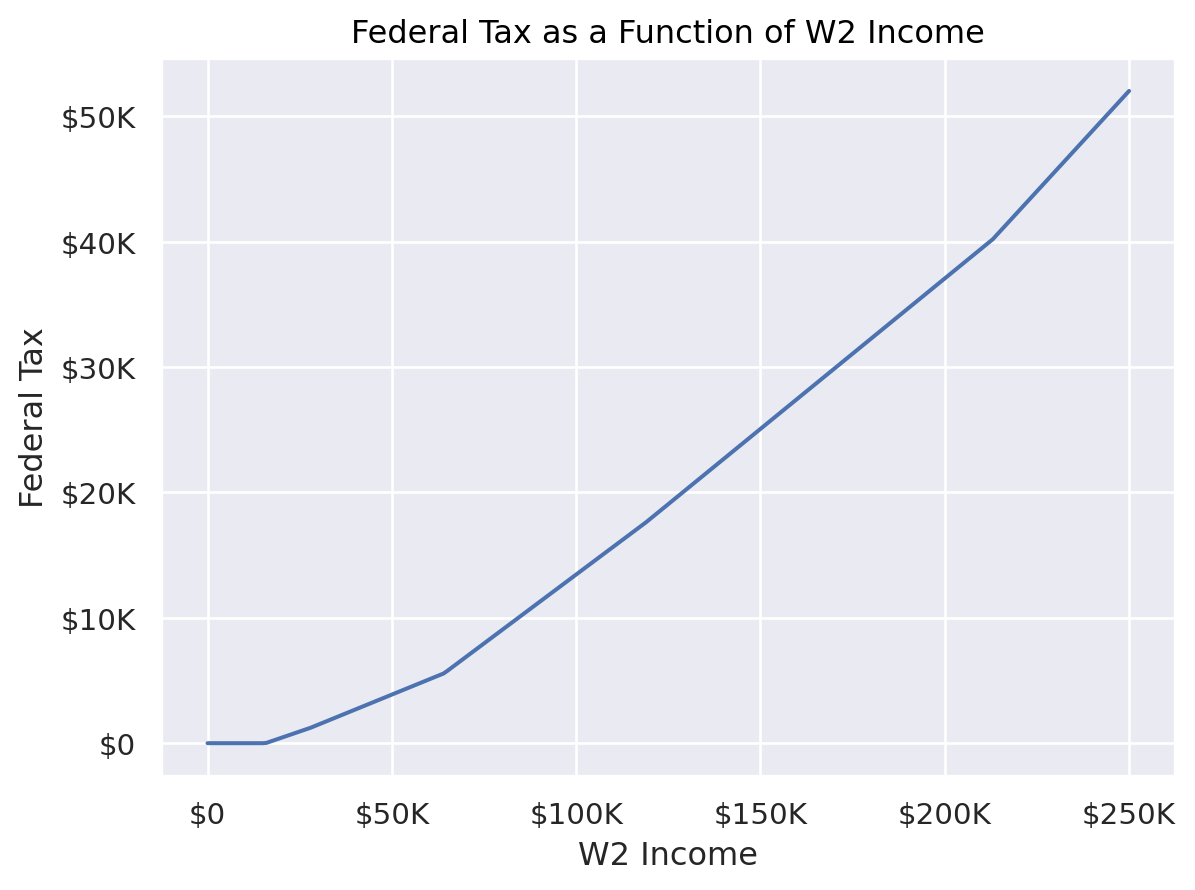

In [6]:
df = tenforty.evaluate_returns(w2_income=list(range(0, 250_001, 1_000)))

p = (
    so.Plot(df, x="w2_income", y="total_tax")
    .add(so.Line(color="#4C72B0"))
    .scale(
        x=so.Continuous().label(like=make_currency_formatter()),
        y=so.Continuous().label(like=make_currency_formatter()),
    )
    .label(
        x="W2 Income", y="Federal Tax", title="Federal Tax as a Function of W2 Income"
    )
)

p

save_seaborn_objects_plot(p, "../images/example1.svg")

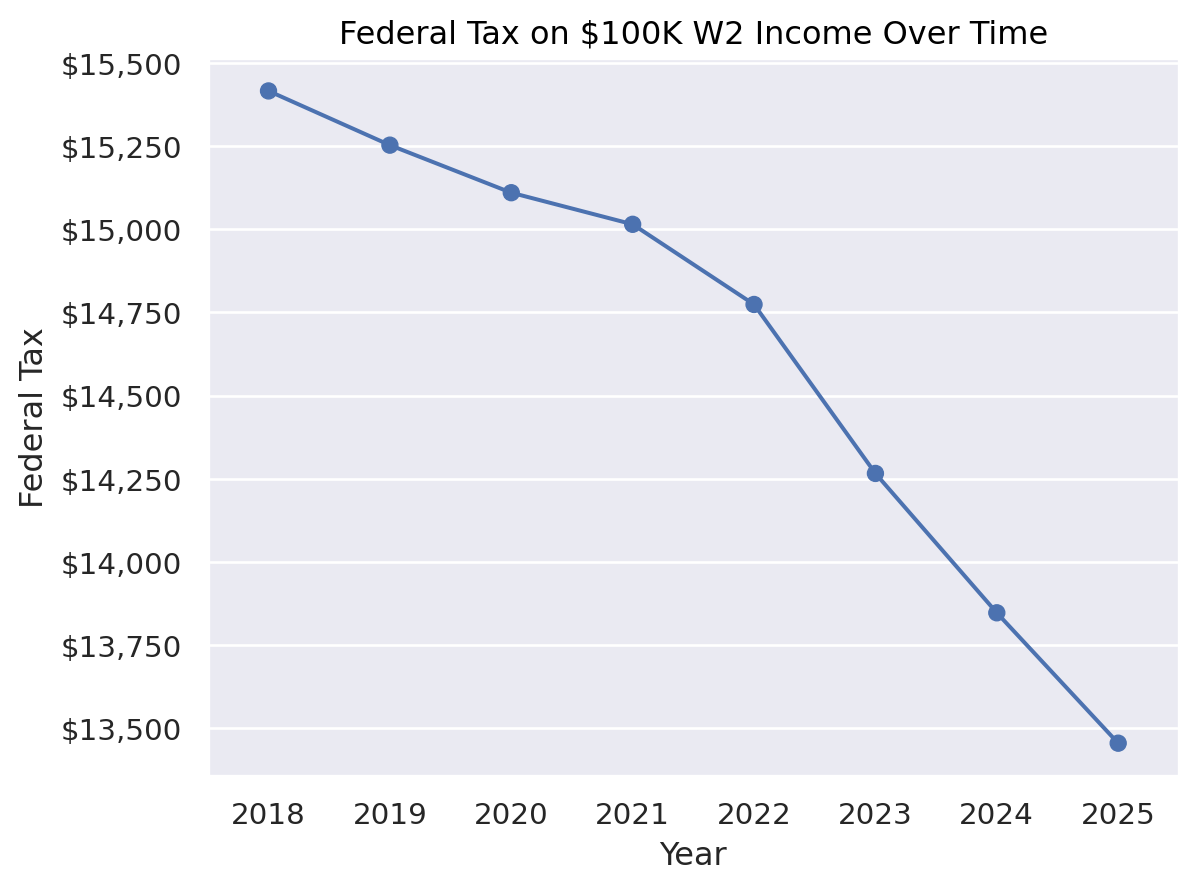

In [7]:
df = tenforty.evaluate_returns(
    year=[2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], w2_income=100_000
).cast({"year": pl.Utf8})

p = (
    so.Plot(df, x="year", y="total_tax")
    .add(so.Line(color="#4C72B0"))
    .add(so.Dot(color="#4C72B0"))
    .scale(
        y=so.Continuous().label(like=plain_currency_formatter),
    )
    .label(
        x="Year",
        y="Federal Tax",
        title="Federal Tax on $100K W2 Income Over Time",
    )
)

p

save_seaborn_objects_plot(p, "../images/example2.svg")

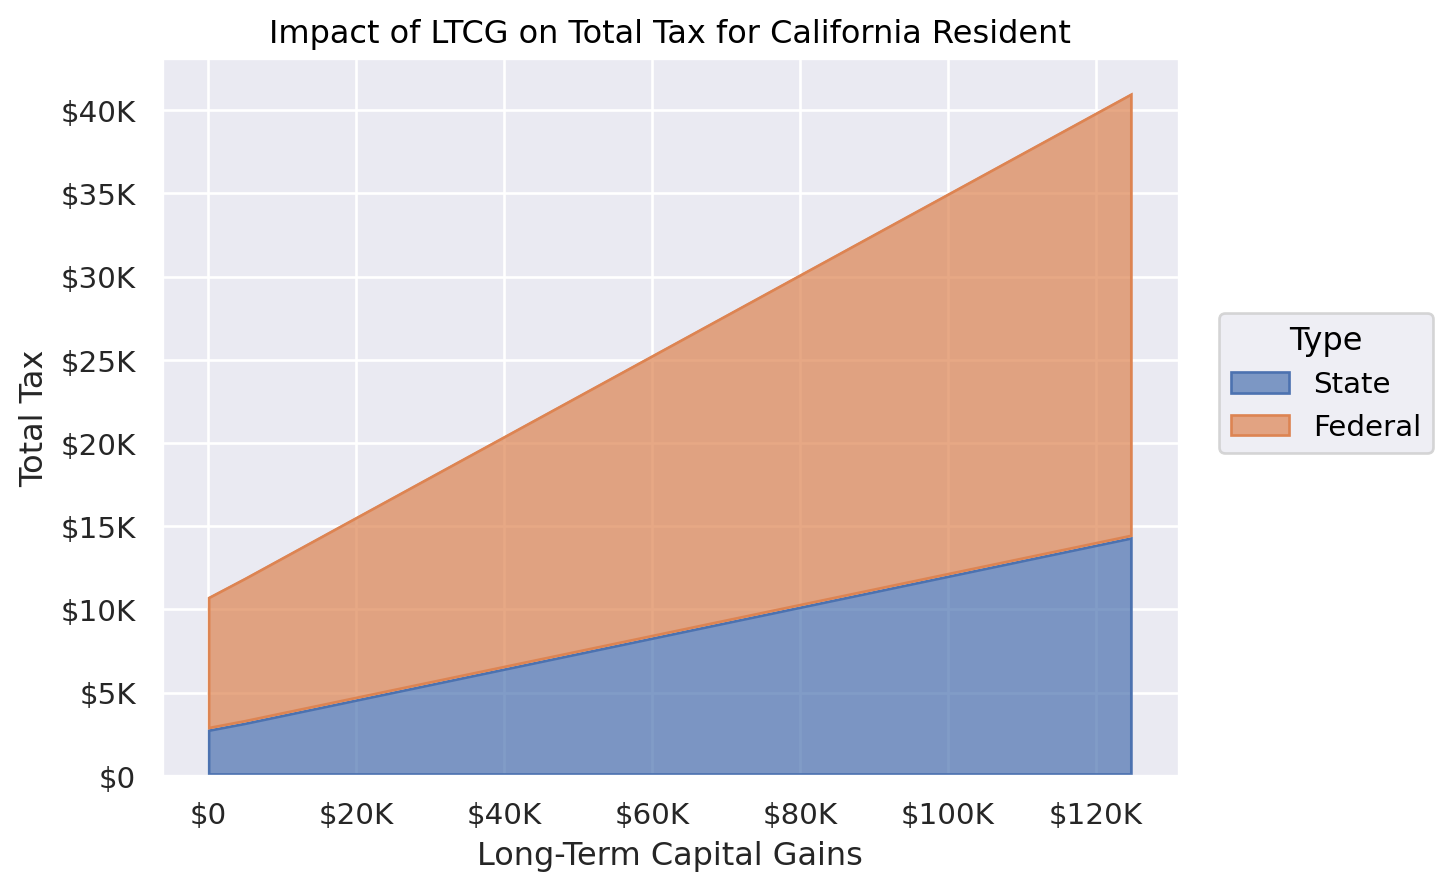

In [8]:
df = (
    tenforty.evaluate_returns(
        w2_income=75_000,
        state="CA",
        long_term_capital_gains=list(range(0, 125_001, 5000)),
    )
    .select(["long_term_capital_gains", "state_total_tax", "federal_total_tax"])
    .unpivot(index="long_term_capital_gains", variable_name="Type", value_name="tax")
    .with_columns(
        pl.col("Type").replace(
            {"state_total_tax": "State", "federal_total_tax": "Federal"}
        )
    )
)

p = (
    so.Plot(df, x="long_term_capital_gains", y="tax", color="Type")
    .add(so.Area(alpha=0.7), so.Stack())
    .scale(
        x=so.Continuous().label(like=make_currency_formatter()),
        y=so.Continuous().label(like=make_currency_formatter()),
    )
    .label(
        x="Long-Term Capital Gains",
        y="Total Tax",
        title="Impact of LTCG on Total Tax for California Resident",
    )
)

p


save_seaborn_objects_plot(p, "../images/example3.svg")

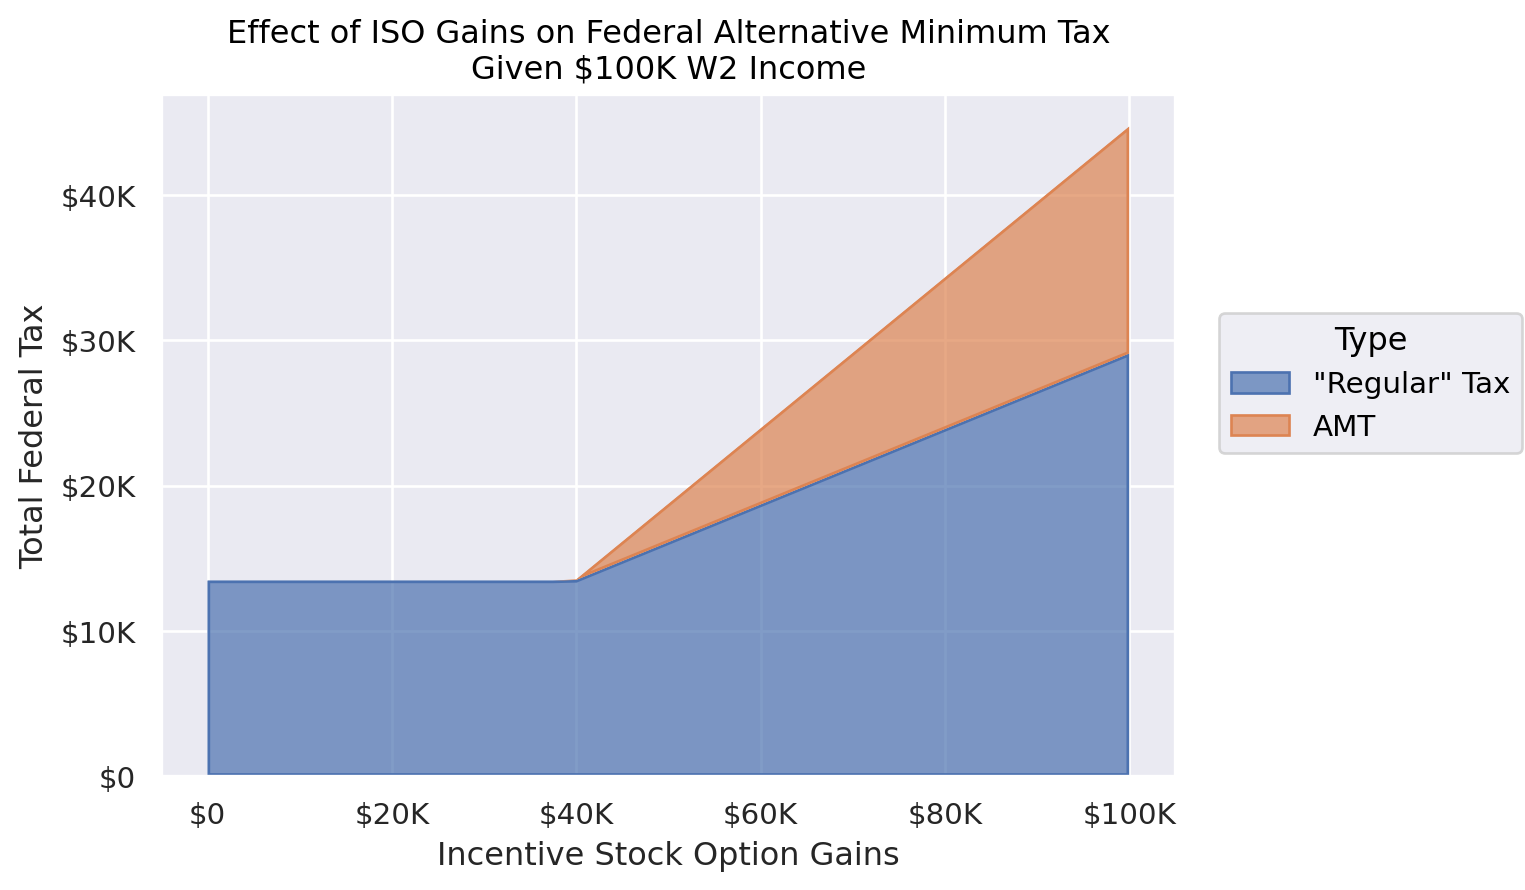

In [9]:
df = (
    tenforty.evaluate_returns(
        w2_income=100_000, incentive_stock_option_gains=list(range(0, 100_001, 2500))
    )
    .select(["incentive_stock_option_gains", "federal_total_tax", "federal_amt"])
    .unpivot(
        index="incentive_stock_option_gains", variable_name="Type", value_name="tax"
    )
    .with_columns(
        pl.col("Type").replace(
            {"federal_amt": "AMT", "federal_total_tax": '"Regular" Tax'}
        )
    )
)

p = (
    so.Plot(df, x="incentive_stock_option_gains", y="tax", color="Type")
    .add(so.Area(alpha=0.7), so.Stack())
    .scale(
        x=so.Continuous().label(like=make_currency_formatter()),
        y=so.Continuous().label(like=make_currency_formatter()),
    )
    .label(
        x="Incentive Stock Option Gains",
        y="Total Federal Tax",
        title="Effect of ISO Gains on Federal Alternative Minimum Tax\nGiven $100K W2 Income",
    )
)

p


save_seaborn_objects_plot(p, "../images/example4.svg")